<a href="https://colab.research.google.com/github/evrenge/Deneme/blob/main/Signal_Processor_with_Mock_Data_and_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install ruptures pandas numpy matplotlib scipy seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.8 MB/s eta 0:00:00


Mock data generated and saved to mock_sensor_data.csv

First 5 rows of mock data:
   elapsed_seconds          N2        fuel
0                0  799.674298  100.379578
1                1  800.298816  100.016036
2                2  799.668772   99.973382
3                3  800.241121  100.339210
4                4  802.312738  100.472243

Shape of mock data: (2500, 3)
Columns: ['elapsed_seconds', 'N2', 'fuel']


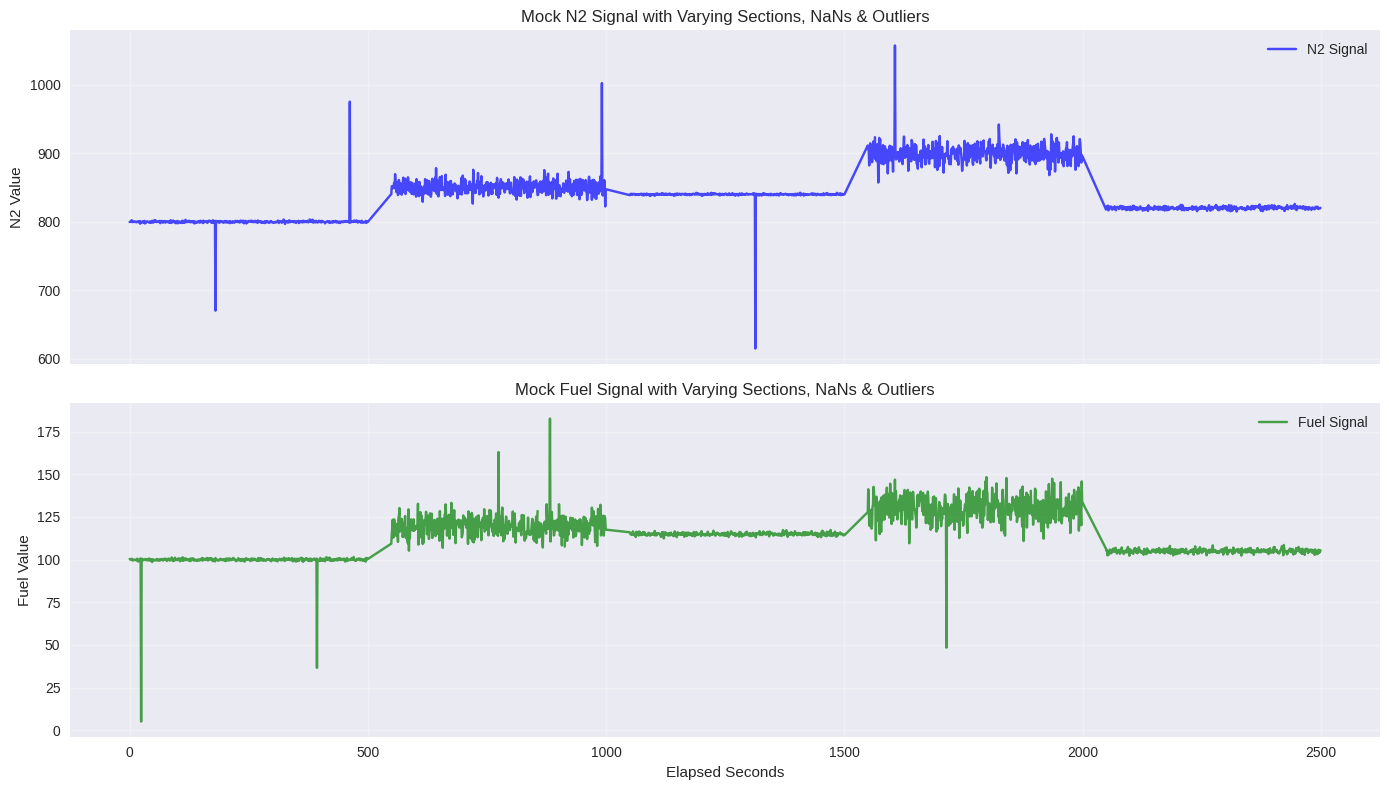


--- Testing your RealDataSignalProcessor with mock data ---
Loading CSV file: mock_sensor_data.csv
Loaded data with shape: (2500, 3)
Columns: ['elapsed_seconds', 'N2', 'fuel']
Time column: elapsed_seconds
Signal columns: ['N2', 'fuel']
Preprocessing data...
Interpolating missing values in N2
Removing 5 outliers from N2
Interpolating missing values in fuel
Removing 5 outliers from fuel
Preprocessing complete
Applying robust local signal cleaning (global pass)...
  Robustly removed 26 extreme values from 'N2' using rolling window (global pass).
  Robustly removed 26 extreme values from 'fuel' using rolling window (global pass).
Robust local signal cleaning (global pass) complete.

--- Segmentation and Cleaning Iteration 1 ---
  Detected 13 segments with penalty 7.82


/usr/local/lib/python3.11/dist-packages/ruptures/costs/costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


  Detected 15 segments with penalty 7.82
Signals modified in this pass. Re-running segmentation with updated data.

--- Segmentation and Cleaning Iteration 2 ---
  Detected 13 segments with penalty 7.82
  Detected 14 segments with penalty 7.82
Signals modified in this pass. Re-running segmentation with updated data.

--- Segmentation and Cleaning Iteration 3 ---
  Detected 13 segments with penalty 7.82
  Detected 14 segments with penalty 7.82
Signals modified in this pass. Re-running segmentation with updated data.

--- Segmentation and Cleaning Iteration 4 ---
  Detected 12 segments with penalty 7.82
  Detected 14 segments with penalty 7.82
Signals modified in this pass. Re-running segmentation with updated data.

--- Segmentation and Cleaning Iteration 5 ---
  Detected 12 segments with penalty 7.82
  Detected 14 segments with penalty 7.82

Segmentation converged after 5 iterations.


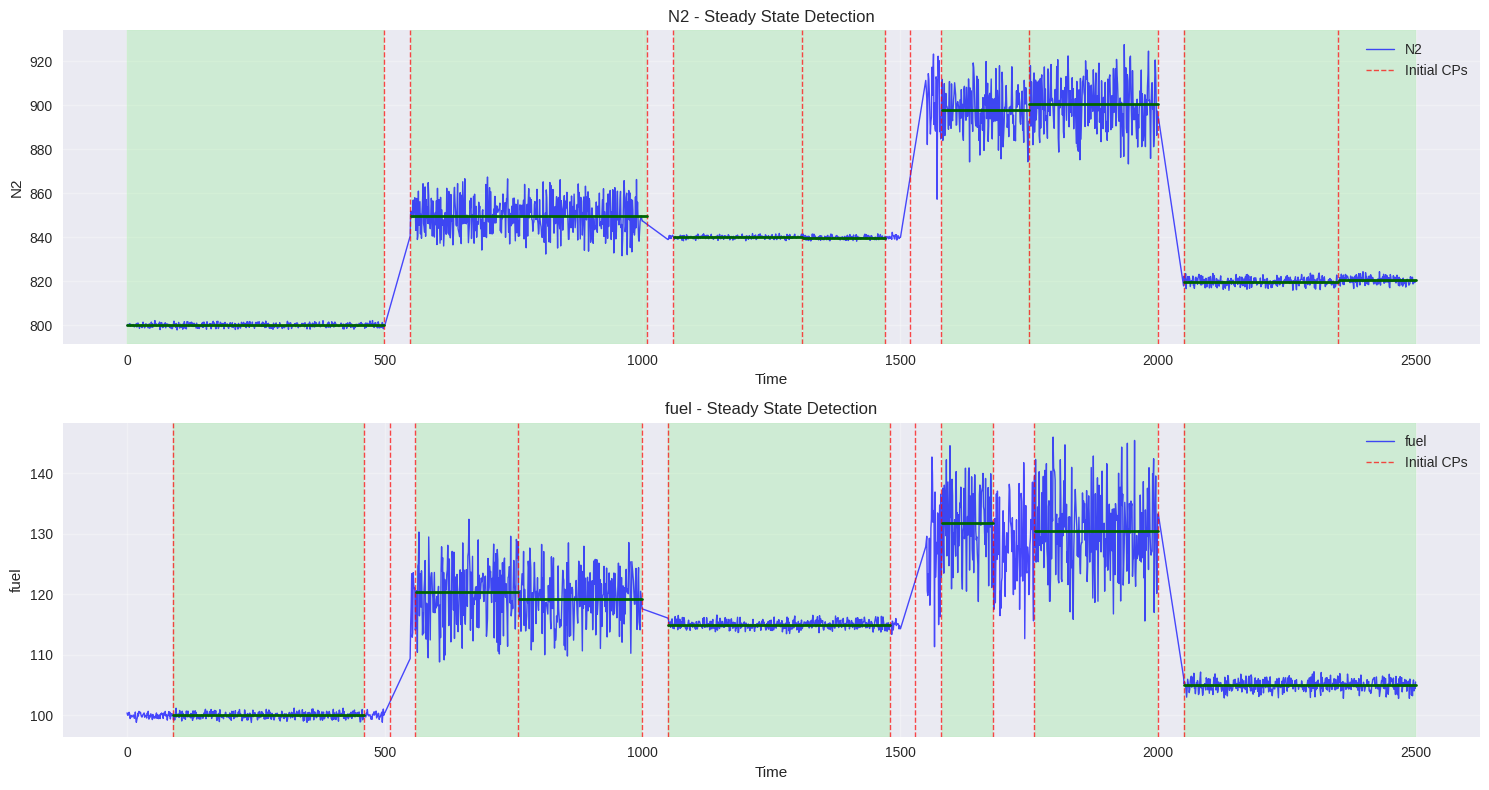

Results exported to mock_data_steady_state_results.xlsx


In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import ruptures as rpt

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def generate_mock_data(
    num_points: int = 3000,
    num_sections: int = 5,
    time_unit: str = 'seconds',
    add_noise: bool = True,
    add_nans: float = 0.005,
    add_outliers: float = 0.002
) -> pd.DataFrame:
    """
    Generates a mock DataFrame with 'time', 'N2', and 'fuel' columns.
    N2 and fuel signals will have num_sections distinct segments with
    varying means and standard deviations, designed to clearly show steady states.
    """
    if num_points < num_sections * 100:
        raise ValueError("num_points must be significantly larger than num_sections for clear steady states.")

    time = np.arange(num_points)

    n2_sections = [
        (800, 1.0),  # Section 1: Very stable steady state
        (850, 8.0),  # Section 2: Higher mean, moderate variance (maybe a transition or slightly less steady)
        (840, 0.8),  # Section 3: Slight drop, very stable
        (900, 12.0), # Section 4: High mean, higher variance (potentially not steady state)
        (820, 2.0)   # Section 5: Drop, fairly stable steady state
    ]

    fuel_sections = [
        (100, 0.5),  # Section 1: Very stable
        (120, 5.0),  # Section 2: Moderate variance
        (115, 0.7),  # Section 3: Very stable
        (130, 7.0),  # Section 4: Higher variance
        (105, 1.0)   # Section 5: Fairly stable
    ]

    points_per_section = num_points // num_sections
    remaining_points = num_points % num_sections

    n2_data = np.array([])
    fuel_data = np.array([])

    current_n2_val = n2_sections[0][0]
    current_fuel_val = fuel_sections[0][0]

    for i in range(num_sections):
        section_length = points_per_section + (1 if i < remaining_points else 0)

        target_mean_n2, target_std_n2 = n2_sections[i]
        target_mean_fuel, target_std_fuel = fuel_sections[i]

        section_n2 = np.random.normal(target_mean_n2, target_std_n2, section_length)
        section_fuel = np.random.normal(target_mean_fuel, target_std_fuel, section_length)

        # Apply a sharper transition if not the first section
        if i > 0:
            transition_length = min(section_length // 10, 50)

            transition_n2 = np.linspace(current_n2_val, section_n2[0], transition_length)
            section_n2[:transition_length] = transition_n2

            transition_fuel = np.linspace(current_fuel_val, section_fuel[0], transition_length)
            section_fuel[:transition_length] = transition_fuel

        n2_data = np.append(n2_data, section_n2)
        fuel_data = np.append(fuel_data, section_fuel)

        current_n2_val = section_n2[-1]
        current_fuel_val = section_fuel[-1]


    df = pd.DataFrame({
        'time': time,
        'N2': n2_data,
        'fuel': fuel_data
    })

    # Add NaNs
    if add_nans > 0:
        num_nans_n2 = int(num_points * add_nans)
        nan_indices_n2 = np.random.choice(num_points, num_nans_n2, replace=False)
        df.loc[nan_indices_n2, 'N2'] = np.nan

        num_nans_fuel = int(num_points * add_nans)
        nan_indices_fuel = np.random.choice(num_points, num_nans_fuel, replace=False)
        df.loc[nan_indices_fuel, 'fuel'] = np.nan

    # Add outliers (random spikes)
    if add_outliers > 0:
        num_outliers_n2 = int(num_points * add_outliers)
        outlier_indices_n2 = np.random.choice(num_points, num_outliers_n2, replace=False)
        df.loc[outlier_indices_n2, 'N2'] += np.random.uniform(75, 250, num_outliers_n2) * np.sign(np.random.randn(num_outliers_n2))

        num_outliers_fuel = int(num_points * add_outliers)
        outlier_indices_fuel = np.random.choice(num_points, num_outliers_fuel, replace=False)
        df.loc[outlier_indices_fuel, 'fuel'] += np.random.uniform(30, 100, num_outliers_fuel) * np.sign(np.random.randn(num_outliers_fuel))

    # Rename time column
    if time_unit == 'seconds':
        df.rename(columns={'time': 'elapsed_seconds'}, inplace=True)
    elif time_unit == 'minutes':
        df['time'] = df['time'] / 60
        df.rename(columns={'time': 'time_minutes'}, inplace=True)

    return df


class RealDataSignalProcessor:
    """Signal processing class adapted for real Excel data"""

    def __init__(self, config):
        self.config = config
        self.processed_signals_data = []
        self.raw_data = None
        self.signal_columns = []
        self.time_column = None

    def load_data(self, file_path, file_type='auto', sheet_name=None, time_col='time',
                  signal_cols=None, auto_detect_signals=True, chunk_size=None,
                  max_rows=None, downsample_factor=None):
        """
        Load data from Excel or CSV file with optimization options.
        """
        try:
            if file_type == 'auto':
                file_ext = Path(file_path).suffix.lower()
                file_type = 'excel' if file_ext in ['.xlsx', '.xls'] else 'csv'

            print(f"Loading {file_type.upper()} file: {file_path}")

            if file_type == 'csv':
                read_kwargs = {}
                if max_rows:
                    read_kwargs['nrows'] = max_rows

                if chunk_size:
                    return self._load_csv_chunked(file_path, chunk_size, time_col, signal_cols, **read_kwargs)
                else:
                    self.raw_data = pd.read_csv(file_path, **read_kwargs)
            else:
                read_kwargs = {'sheet_name': sheet_name}
                if max_rows:
                    read_kwargs['nrows'] = max_rows
                self.raw_data = pd.read_excel(file_path, **read_kwargs)

            if downsample_factor and downsample_factor > 1:
                print(f"Downsampling by factor of {downsample_factor}")
                self.raw_data = self.raw_data.iloc[::downsample_factor].reset_index(drop=True)

            print(f"Loaded data with shape: {self.raw_data.shape}")
            print(f"Columns: {list(self.raw_data.columns)}")

            self.time_column = self._find_time_column(time_col)

            if signal_cols is None:
                if auto_detect_signals:
                    self.signal_columns = self._auto_detect_signal_columns()
                else:
                    self.signal_columns = self._find_default_signals()
            else:
                self.signal_columns = [col for col in signal_cols if col in self.raw_data.columns]

            print(f"Time column: {self.time_column}")
            print(f"Signal columns: {self.signal_columns}")

            self._validate_data()

            return True

        except Exception as e:
            print(f"Error loading data: {e}")
            return False

    def _load_csv_chunked(self, file_path, chunk_size, time_col, signal_cols, **kwargs):
        """Load large CSV files in chunks"""
        print(f"Loading CSV in chunks of {chunk_size} rows...")

        sample = pd.read_csv(file_path, nrows=1000)
        print(f"Sample shape: {sample.shape}")
        print(f"Columns: {list(sample.columns)}")

        self.time_column = self._find_time_column_from_df(sample, time_col)

        if signal_cols is None:
            all_numeric = sample.select_dtypes(include=[np.number]).columns.tolist()
            if self.time_column and self.time_column in all_numeric:
                all_numeric.remove(self.time_column)
            self.signal_columns = self._prioritize_signal_columns(all_numeric, sample.columns)
        else:
            self.signal_columns = [col for col in signal_cols if col in sample.columns]

        cols_to_read = [self.time_column] + self.signal_columns if self.time_column else self.signal_columns

        print(f"Reading columns: {cols_to_read}")

        chunks = []
        for chunk in pd.read_csv(file_path, chunksize=chunk_size, usecols=cols_to_read, **kwargs):
            chunks.append(chunk)

        self.raw_data = pd.concat(chunks, ignore_index=True)
        print(f"Loaded {len(chunks)} chunks, total shape: {self.raw_data.shape}")

        return True

    def _find_time_column_from_df(self, df, time_col):
        """Find time column from a DataFrame"""
        if time_col in df.columns:
            return time_col

        for col in df.columns:
            if col.lower() == time_col.lower():
                return col

        time_keywords = ['time', 'timestamp', 'seconds', 'sec', 't', 'elapsed']
        for col in df.columns:
            for keyword in time_keywords:
                if keyword in col.lower():
                    return col

        return None

    def _prioritize_signal_columns(self, numeric_cols, all_cols):
        """Prioritize signal columns based on keywords"""
        priority_keywords = ['n2', 'fuel', 'temp', 'temperature', 'pressure', 'flow', 'egt', 'itt']
        priority_cols = []
        other_cols = []

        for col in numeric_cols:
            col_lower = col.lower()
            if any(keyword in col_lower for keyword in priority_keywords):
                priority_cols.append(col)
            else:
                other_cols.append(col)

        return priority_cols + other_cols[:max(0, 10-len(priority_cols))]

    def _find_time_column(self, time_col):
        """Find the time column in the dataset"""
        if time_col in self.raw_data.columns:
            return time_col

        for col in self.raw_data.columns:
            if col.lower() == time_col.lower():
                return col

        time_keywords = ['time', 'timestamp', 'seconds', 'sec', 't', 'elapsed']
        for col in self.raw_data.columns:
            for keyword in time_keywords:
                if keyword in col.lower():
                    return col

        print("Warning: No time column found, using index as time")
        return None

    def _auto_detect_signal_columns(self):
        """Automatically detect numeric columns that could be signals"""
        numeric_cols = self.raw_data.select_dtypes(include=[np.number]).columns.tolist()

        if self.time_column and self.time_column in numeric_cols:
            numeric_cols.remove(self.time_column)

        priority_keywords = ['n2', 'fuel', 'temp', 'temperature', 'pressure', 'flow']
        priority_cols = []
        other_cols = []

        for col in numeric_cols:
            col_lower = col.lower()
            if any(keyword in col_lower for keyword in priority_keywords):
                priority_cols.append(col)
            else:
                other_cols.append(col)

        return priority_cols + other_cols

    def _find_default_signals(self):
        """Find default signals (N2, fuel, temperature)"""
        default_signals = []
        search_terms = {
            'n2': ['n2', 'nitrogen'],
            'fuel': ['fuel', 'ff', 'fuel_flow'],
            'temp': ['temp', 'temperature', 'egt', 'itt']
        }

        for signal_type, terms in search_terms.items():
            for col in self.raw_data.columns:
                col_lower = col.lower()
                if any(term in col_lower for term in terms):
                    default_signals.append(col)
                    break

        if not default_signals:
            numeric_cols = self.raw_data.select_dtypes(include=[np.number]).columns.tolist()
            if self.time_column and self.time_column in numeric_cols:
                numeric_cols.remove(self.time_column)
            default_signals = numeric_cols[:3]

        return default_signals

    def _validate_data(self):
        """Validate the loaded data"""
        if self.raw_data.empty:
            raise ValueError("Loaded data is empty")

        if not self.signal_columns:
            raise ValueError("No signal columns identified")

        for col in self.signal_columns:
            missing_pct = self.raw_data[col].isnull().sum() / len(self.raw_data) * 100
            if missing_pct > 0:
                print(f"Warning: Column '{col}' has {missing_pct:.1f}% missing values")

    def preprocess_data(self, remove_outliers=True, outlier_std_threshold=3):
        """Preprocess the data before analysis"""
        print("Preprocessing data...")

        if self.time_column:
            time_data = self.raw_data[self.time_column].values
        else:
            time_data = np.arange(len(self.raw_data))

        preprocessed_data = {'time': time_data}

        for col in self.signal_columns:
            signal = self.raw_data[col].copy()

            if signal.isnull().any():
                print(f"Interpolating missing values in {col}")
                signal = signal.interpolate(method='linear')

            if remove_outliers:
                mean_val = signal.mean()
                std_val = signal.std()
                outlier_mask = np.abs(signal - mean_val) > outlier_std_threshold * std_val
                if outlier_mask.any():
                    print(f"Removing {outlier_mask.sum()} outliers from {col}")
                    signal[outlier_mask] = np.nan
                    signal = pd.Series(signal).interpolate(method='linear').bfill().ffill().values

            preprocessed_data[col] = signal # Corrected: Removed .values as signal is already a numpy array

        self.preprocessed_data = preprocessed_data
        print("Preprocessing complete")

    def _robust_signal_cleaning(self):
        """
        Performs a second pass of local extreme value removal on the preprocessed signals
        using a rolling window approach, before primary change point detection.
        """
        print(f"Applying robust local signal cleaning (global pass)...")

        if not hasattr(self, 'preprocessed_data') or not self.preprocessed_data:
            print("Error: Preprocessed data not available for robust cleaning.")
            return

        window_size = self.config.get('robust_clean_window_size', 50)
        std_dev_factor = self.config.get('robust_clean_std_factor', 3.0)

        for col in self.signal_columns:
            signal_series = pd.Series(self.preprocessed_data[col])

            rolling_median = signal_series.rolling(window=window_size, center=True, min_periods=1).median()
            rolling_mad = signal_series.rolling(window=window_size, center=True, min_periods=1).apply(lambda x: np.median(np.abs(x - np.median(x))), raw=True)

            rolling_std_estimate = 1.4826 * rolling_mad

            deviation = np.abs(signal_series - rolling_median)
            outlier_mask = deviation > (std_dev_factor * rolling_std_estimate)

            num_removed = outlier_mask.sum()
            if num_removed > 0:
                print(f"  Robustly removed {num_removed} extreme values from '{col}' using rolling window (global pass).")
                signal_series[outlier_mask] = np.nan
                self.preprocessed_data[col] = signal_series.interpolate(method='linear').bfill().ffill().values
            else:
                print(f"  No additional extreme values found in '{col}' during global robust cleaning.")

        print("Robust local signal cleaning (global pass) complete.")

    def process_signal(self, signal_name, signal_data, time_data=None):
        """
        This method is now primarily for generating final results for plotting/export.
        The iterative cleaning and segmentation logic is handled in process_all_signals.
        """
        print(f"\n--- Final Processing for Signal: {signal_name} ---")

        # Use the already processed data from the final iteration of the main loop
        detected_bkps, penalty_used = self.detect_change_points(signal_data)

        steady_state_segments, steady_state_response, segment_analysis, _ = \
            self._identify_steady_state_segments_and_clean(
                signal_name, detected_bkps, signal_data
            )

        result_data = {
            'signal_name': signal_name,
            'signal': signal_data,
            'time': time_data if time_data is not None else np.arange(len(signal_data)),
            'detected_bkps': detected_bkps,
            'steady_state_segments': steady_state_segments,
            'steady_state_response': steady_state_response,
            'segment_analysis': segment_analysis,
            'penalty_used': penalty_used
        }

        return result_data

    def process_all_signals(self):
        """
        Processes all identified signals through an iterative segmentation and cleaning loop
        to ensure accurate change point detection.
        """
        if not hasattr(self, 'preprocessed_data'):
            print("Data not preprocessed. Running preprocessing...")
            self.preprocess_data()

        # Initial global robust cleaning pass
        self._robust_signal_cleaning()

        max_segmentation_iterations = self.config.get('max_segmentation_iterations', 3)

        final_processed_data_results = []

        # Outer loop for iterative segmentation and cleaning
        for iteration_count in range(max_segmentation_iterations):
            print(f"\n--- Segmentation and Cleaning Iteration {iteration_count + 1} ---")
            signals_modified_in_this_pass = False

            # Temporary storage for segments and analysis of this pass
            current_iteration_segments_analysis = {}

            for signal_name in self.signal_columns:
                # Get the current state of the signal data (potentially modified from previous iteration)
                signal_data_for_processing = self.preprocessed_data[signal_name]

                # Perform change point detection on the current signal
                detected_bkps, penalty_used = self.detect_change_points(signal_data_for_processing)

                # Identify steady-state segments AND perform local cleaning, updating self.preprocessed_data
                steady_state_segments, steady_state_response, segment_analysis, current_signal_was_modified = \
                    self._identify_steady_state_segments_and_clean(
                        signal_name,
                        detected_bkps,
                        signal_data_for_processing
                    )

                if current_signal_was_modified:
                    signals_modified_in_this_pass = True

                # Store analysis results for this iteration
                current_iteration_segments_analysis[signal_name] = {
                    'detected_bkps': detected_bkps,
                    'steady_state_segments': steady_state_segments,
                    'steady_state_response': steady_state_response,
                    'segment_analysis': segment_analysis,
                    'penalty_used': penalty_used
                }

            # If no signals were modified in this pass, we've converged
            if not signals_modified_in_this_pass:
                print(f"\nSegmentation converged after {iteration_count + 1} iterations.")
                # Construct final_processed_data_results from the last stable state
                for signal_name in self.signal_columns:
                    result = current_iteration_segments_analysis[signal_name]
                    final_processed_data_results.append({
                        'signal_name': signal_name,
                        'signal': self.preprocessed_data[signal_name],
                        'time': self.preprocessed_data['time'],
                        'detected_bkps': result['detected_bkps'],
                        'steady_state_segments': result['steady_state_segments'],
                        'steady_state_response': result['steady_state_response'],
                        'segment_analysis': result['segment_analysis'],
                        'penalty_used': result['penalty_used']
                    })
                break
            else:
                print(f"Signals modified in this pass. Re-running segmentation with updated data.")
        else:
            print(f"\nMax segmentation iterations ({max_segmentation_iterations}) reached without full convergence.")
            # Use the results from the last iteration if max iterations reached
            for signal_name in self.signal_columns:
                result = current_iteration_segments_analysis[signal_name]
                final_processed_data_results.append({
                    'signal_name': signal_name,
                    'signal': self.preprocessed_data[signal_name],
                    'time': self.preprocessed_data['time'],
                    'detected_bkps': result['detected_bkps'],
                    'steady_state_segments': result['steady_state_segments'],
                    'steady_state_response': result['steady_state_response'],
                    'segment_analysis': result['segment_analysis'],
                    'penalty_used': result['penalty_used']
                })

        self.processed_signals_data = final_processed_data_results

    def detect_change_points(self, signal, method='binseg', model='normal', custom_jump=None, custom_penalty_factor=1.0):
        """
        Detect change points with improved parameter selection and error handling.
        Can accept custom_jump and custom_penalty_factor for refinement passes.
        """
        n_samples = len(signal)

        if n_samples < 10:
            print(f"  Warning: Signal too short ({n_samples} samples), returning single segment")
            return [n_samples], 1.0

        if np.std(signal) == 0 or np.all(signal == signal[0]):
            print(f"  Warning: Constant signal detected, returning single segment")
            return [n_samples], 1.0

        if np.any(np.isnan(signal)):
            print(f"  Warning: NaN values detected in signal")
            signal = pd.Series(signal).interpolate(method='linear').bfill().ffill().values

        try:
            min_segment_size = max(5, n_samples//100, self.config.get('min_steady_state_length', 20)//2)

            # Use custom_jump if provided, otherwise default to config or 1
            jump_val = custom_jump if custom_jump is not None else self.config.get('ruptures_jump', 1)

            if method == 'binseg':
                algo = rpt.Binseg(model=model, jump=jump_val, min_size=min_segment_size).fit(signal)
            elif method == 'pelt':
                algo = rpt.Pelt(model=model, jump=jump_val, min_size=min_segment_size).fit(signal)
            else:
                raise ValueError(f"Unknown method: {method}")

            penalty_value = self._calculate_adaptive_penalty(signal, custom_penalty_factor)
            detected_bkps = algo.predict(pen=penalty_value)

            detected_bkps = [bp for bp in detected_bkps if 0 < bp <= n_samples]

            if not detected_bkps or detected_bkps[-1] != n_samples:
                detected_bkps.append(n_samples)

            detected_bkps = sorted(list(set(detected_bkps)))

            print(f"  Detected {len(detected_bkps)-1} segments with penalty {penalty_value:.2f}")

            return detected_bkps, penalty_value

        except Exception as e:
            print(f"  Error in change point detection: {e}")
            print(f"  Falling back to single segment")
            return [n_samples], 1.0

    def _calculate_adaptive_penalty(self, signal, custom_penalty_factor=1.0):
        """
        Calculate adaptive penalty based on signal characteristics.
        custom_penalty_factor can be used to scale the penalty for refinement passes.
        """
        n_samples = len(signal)
        signal_var = np.var(signal)

        base_penalty = 2 * np.log(n_samples)

        variance_factor = max(0.5, min(2.0, signal_var / np.mean(signal)**2)) if np.mean(signal) != 0 else 1.0
        length_factor = max(1.0, np.log(n_samples / 1000)) if n_samples > 1000 else 1.0

        return base_penalty * variance_factor * length_factor * custom_penalty_factor

    def _identify_steady_state_segments_and_clean(self, signal_name, detected_bkps, original_signal_array):
        """
        Identify steady-state segments with enhanced criteria and iterative refinement.
        Segments not initially identified as steady state are locally cleaned and re-evaluated.
        This function also updates the global `self.preprocessed_data` if local cleaning occurs.
        """
        steady_state_segments = []
        steady_state_response = np.full_like(original_signal_array, np.nan)
        all_segment_analysis = []
        signal_was_modified_in_this_function = False

        current_signal_data_copy = original_signal_array.copy()

        detected_bkps = [bp for bp in detected_bkps if 0 <= bp <= len(current_signal_data_copy)]
        detected_bkps = sorted(list(set(detected_bkps)))

        if not detected_bkps or detected_bkps[-1] != len(current_signal_data_copy):
            detected_bkps.append(len(current_signal_data_copy))

        current_start_global = 0
        segment_counter = 0

        for bkp_idx, bkp_end_global in enumerate(detected_bkps):
            segment_start_global = current_start_global

            if bkp_end_global <= segment_start_global:
                current_start_global = bkp_end_global
                continue

            segment_data_slice = current_signal_data_copy[segment_start_global:bkp_end_global]
            segment_length = len(segment_data_slice)

            segment_counter += 1
            segment_label = str(segment_counter)

            is_steady_state, processed_segment_data_slice = self._is_steady_state(segment_data_slice.copy(), return_processed_segment=True)

            if not np.array_equal(segment_data_slice, processed_segment_data_slice, equal_nan=True):
                self.preprocessed_data[signal_name][segment_start_global:bkp_end_global] = processed_segment_data_slice
                signal_was_modified_in_this_function = True

            segment_std_dev = np.std(processed_segment_data_slice)
            segment_mean = np.mean(processed_segment_data_slice)

            if np.isnan(segment_mean) or np.isnan(segment_std_dev):
                is_steady_state = False

            primary_segment_info = {
                'index': segment_label,
                'start': segment_start_global,
                'end': bkp_end_global,
                'length': segment_length,
                'mean': segment_mean,
                'std_dev': segment_std_dev,
                'cv': segment_std_dev / abs(segment_mean) if segment_mean != 0 else np.inf,
                'is_steady_state': is_steady_state
            }
            all_segment_analysis.append(primary_segment_info)

            if is_steady_state:
                steady_state_segments.append({
                    'start': segment_start_global,
                    'end': bkp_end_global,
                    'mean': segment_mean,
                    'std_dev': segment_std_dev,
                    'cv': segment_std_dev / abs(segment_mean) if segment_mean != 0 else np.inf
                })
                steady_state_response[segment_start_global:bkp_end_global] = segment_mean # Corrected: Used segment_mean
            else:
                refine_min_length = self.config.get('min_steady_state_length', 100) * 1.5
                if segment_length >= refine_min_length:
                    sub_bkps, _ = self.detect_change_points(processed_segment_data_slice,
                                                            method='binseg', model='normal',
                                                            custom_jump=self.config.get('ruptures_refine_jump', 2),
                                                            custom_penalty_factor=self.config.get('penalty_refine_factor', 0.5))

                    sub_current_local = 0
                    sub_segment_counter = 0
                    for sub_bkp_local in sub_bkps:
                        sub_segment_end_local = int(sub_bkp_local)
                        if sub_segment_end_local <= sub_current_local:
                            sub_current_local = sub_segment_end_local
                            continue

                        sub_segment_data_slice = processed_segment_data_slice[sub_current_local:sub_segment_end_local]
                        sub_segment_length = len(sub_segment_data_slice)

                        if sub_segment_length < self.config.get('min_steady_state_length', 100):
                            sub_current_local = sub_segment_end_local
                            continue

                        sub_segment_counter += 1
                        sub_segment_label = f"{segment_label}.{sub_segment_counter}"

                        sub_is_steady_state, final_sub_processed_data = self._is_steady_state(sub_segment_data_slice.copy(), return_processed_segment=True)

                        sub_seg_std = np.std(final_sub_processed_data)
                        sub_seg_mean = np.mean(final_sub_processed_data)

                        if np.isnan(sub_seg_mean) or np.isnan(sub_seg_std):
                            sub_is_steady_state = False

                        sub_seg_cv = sub_seg_std / abs(sub_seg_mean) if sub_seg_mean != 0 else np.inf

                        all_segment_analysis.append({
                            'index': sub_segment_label, 'start': segment_start_global + sub_current_local, 'end': segment_start_global + sub_segment_end_local,
                            'length': sub_segment_length, 'mean': sub_seg_mean,
                            'std_dev': sub_seg_std, 'cv': sub_seg_cv,
                            'is_steady_state': sub_is_steady_state
                        })

                        if sub_is_steady_state:
                            steady_state_segments.append({
                                'start': segment_start_global + sub_current_local,
                                'end': segment_start_global + sub_segment_end_local,
                                'mean': sub_seg_mean,
                                'std_dev': sub_seg_std,
                                'cv': sub_seg_cv
                            })
                            steady_state_response[segment_start_global + sub_current_local : segment_start_global + sub_segment_end_local] = sub_seg_mean

                        sub_current_local = sub_segment_end_local

            current_start_global = bkp_end_global

        steady_state_segments.sort(key=lambda x: x['start'])
        all_segment_analysis.sort(key=lambda x: x['start'])

        return steady_state_segments, steady_state_response, all_segment_analysis, signal_was_modified_in_this_function

    def _is_steady_state(self, segment_data, return_processed_segment=False):
        """
        Enhanced steady-state detection with multiple criteria and error handling.
        Now includes a local outlier removal step.
        """
        processed_segment = segment_data.copy()
        segment_length = len(processed_segment)

        if segment_length < self.config.get('min_steady_state_length', 20):
            return (False, processed_segment) if return_processed_segment else False

        if np.all(np.isnan(processed_segment)) or np.all(processed_segment == processed_segment[0]):
            return (False, processed_segment) if return_processed_segment else False

        local_outlier_threshold = self.config.get('local_outlier_std_threshold', 2.5)
        try:
            local_mean_val = np.nanmean(processed_segment)
            local_std_val = np.nanstd(processed_segment)

            if local_std_val > 0 and not np.isnan(local_mean_val) and not np.isnan(local_std_val):
                local_outlier_mask = np.abs(processed_segment - local_mean_val) > local_outlier_threshold * local_std_val
                if local_outlier_mask.any():
                    processed_segment[local_outlier_mask] = np.nan
                    processed_segment = pd.Series(processed_segment).interpolate(method='linear').bfill().ffill().values
                    if np.all(np.isnan(processed_segment)):
                         return (False, processed_segment) if return_processed_segment else False
            elif local_std_val == 0:
                pass
            else:
                return (False, processed_segment) if return_processed_segment else False
        except Exception as e:
            print(f"    Error during local outlier removal: {e}. Skipping local removal.")

        std_dev = np.std(processed_segment)
        mean_val = np.mean(processed_segment)

        if np.isnan(std_dev) or std_dev > self.config.get('steady_state_std_dev_threshold', 2.0):
            return (False, processed_segment) if return_processed_segment else False

        if mean_val != 0 and not np.isnan(mean_val):
            cv = std_dev / abs(mean_val)
            if np.isnan(cv) or cv > self.config.get('steady_state_cv_threshold', 0.05):
                return (False, processed_segment) if return_processed_segment else False

        x = np.arange(segment_length)
        try:
            non_nan_indices = ~np.isnan(processed_segment)
            if non_nan_indices.sum() < 2:
                has_significant_trend = False
            else:
                slope, _, _, p_value, _ = stats.linregress(x[non_nan_indices], processed_segment[non_nan_indices])
                trend_significance = self.config.get('trend_significance_threshold', 0.05)
                slope_threshold = self.config.get('slope_threshold', 0.1)

                if not (np.isnan(slope) or np.isnan(p_value)):
                    has_significant_trend = p_value < trend_significance and abs(slope) > slope_threshold
                else:
                    has_significant_trend = False
        except (ValueError, np.linalg.LinAlgError):
            has_significant_trend = False

        if segment_length > 2:
            try:
                if non_nan_indices.sum() < 2:
                    has_high_autocorr = False
                else:
                    clean_segment = processed_segment[non_nan_indices]
                    if len(clean_segment) > 1:
                        autocorr = np.corrcoef(clean_segment[:-1], clean_segment[1:])[0, 1]
                        if np.isnan(autocorr):
                            has_high_autocorr = False
                        else:
                            has_high_autocorr = abs(autocorr) > self.config.get('autocorr_threshold', 0.8)
                    else:
                        has_high_autocorr = False
            except (ValueError, np.linalg.LinAlgError):
                has_high_autocorr = False
        else:
            has_high_autocorr = False

        is_ss = not (has_significant_trend or has_high_autocorr)
        return (is_ss, processed_segment) if return_processed_segment else is_ss

    def _print_signal_analysis(self, signal_name, signal, detected_bkps, segment_analysis, penalty_used):
        """Print detailed analysis for a signal"""
        print(f"  Signal Length: {len(signal)}")
        print(f"  Signal Range: [{np.min(signal):.2f}, {np.max(signal):.2f}]")
        print(f"  Signal Mean: {np.mean(signal):.2f} ± {np.std(signal):.2f}")
        print(f"  Penalty Used: {penalty_used:.2f}")

        initial_bkps = [b for b in detected_bkps if b != len(signal)]
        print(f"  Initial Detected Change Points: {initial_bkps}")

        steady_count = sum(1 for seg in segment_analysis if seg['is_steady_state'])
        print(f"  Steady-State Segments (incl. refined): {steady_count}/{len(segment_analysis)}")

        if steady_count > 0:
            steady_segments = [seg for seg in segment_analysis if seg['is_steady_state']]
            avg_ss_length = np.mean([seg['length'] for seg in steady_segments])
            avg_ss_std = np.mean([seg['std_dev'] for seg in steady_segments])
            print(f"  Average SS Length: {avg_ss_length:.1f} samples")
            print(f"  Average SS Std Dev: {avg_ss_std:.3f}")

    def create_signal_plots(self, max_signals=None):
        """Create comprehensive plots for the processed signals"""
        n_signals = len(self.processed_signals_data)
        if max_signals:
            n_signals = min(n_signals, max_signals)

        fig, axes = plt.subplots(n_signals, 1, figsize=(15, 4*n_signals), squeeze=False)
        axes = axes.flatten()

        for i, data in enumerate(self.processed_signals_data[:n_signals]):
            ax = axes[i]
            signal = data['signal']
            time = data['time']
            signal_name = data['signal_name']
            steady_state_segments = data['steady_state_segments']
            detected_bkps = data['detected_bkps']

            ax.plot(time, signal, label=f'{signal_name}', color='blue', alpha=0.7, linewidth=1)

            for bkp in detected_bkps[:-1]:
                if bkp < len(time):
                    ax.axvline(x=time[bkp-1], color='red', linestyle='--', alpha=0.7, linewidth=1, label='Initial CPs' if bkp == detected_bkps[0] else "")

            for ss_seg in steady_state_segments:
                start_idx = ss_seg['start']
                end_idx = min(ss_seg['end'], len(time))
                mean_val = ss_seg['mean']

                ax.axvspan(time[start_idx], time[end_idx-1], color='lightgreen', alpha=0.3)
                ax.plot([time[start_idx], time[end_idx-1]], [mean_val, mean_val],
                        color='darkgreen', linestyle='-', linewidth=2)

            ax.set_title(f'{signal_name} - Steady State Detection')
            ax.set_xlabel('Time')
            ax.set_ylabel(signal_name)
            ax.grid(True, alpha=0.3)
            ax.legend()

        plt.tight_layout()
        plt.show()

    def export_results(self, output_file='steady_state_results.xlsx'):
        """Export results to Excel file"""
        with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
            summary_data = []
            for data in self.processed_signals_data:
                signal_name = data['signal_name']
                n_segments = len(data['segment_analysis'])
                n_steady = sum(1 for seg in data['segment_analysis'] if seg['is_steady_state'])

                if n_steady > 0:
                    steady_segs = [seg for seg in data['segment_analysis'] if seg['is_steady_state']]
                    avg_length = np.mean([seg['length'] for seg in steady_segs])
                    avg_std = np.mean([seg['std_dev'] for seg in steady_segs])
                    avg_cv = np.mean([seg['cv'] for seg in steady_segs if seg['cv'] != np.inf])
                else:
                    avg_length = avg_std = avg_cv = 0

                summary_data.append({
                    'Signal': signal_name,
                    'Total_Segments_Analyzed': n_segments,
                    'Steady_State_Segments_Found': n_steady,
                    'SS_Percentage': n_steady / n_segments * 100 if n_segments > 0 else 0,
                    'Avg_SS_Length': avg_length,
                    'Avg_SS_StdDev': avg_std,
                    'Avg_SS_CV': avg_cv
                })

            summary_df = pd.DataFrame(summary_data)
            summary_df.to_excel(writer, sheet_name='Summary', index=False)

            for data in self.processed_signals_data:
                signal_name = data['signal_name']
                segments_df = pd.DataFrame(data['segment_analysis'])
                segments_df.to_excel(writer, sheet_name=f'{signal_name}_segments', index=False)

        print(f"Results exported to {output_file}")


# Configuration for real data processing
real_data_config = {
    'min_steady_state_length': 100,
    'steady_state_std_dev_threshold': 15.0,
    'steady_state_cv_threshold': 0.1,
    'trend_significance_threshold': 0.05,
    'slope_threshold': 0.05,
    'autocorr_threshold': 0.7,
    'ruptures_jump': 10,
    'ruptures_refine_jump': 2,
    'penalty_refine_factor': 0.5,
    'local_outlier_std_threshold': 2.5,
    'robust_clean_window_size': 50,
    'robust_clean_std_factor': 3.0,
    'max_segmentation_iterations': 5
}

if __name__ == "__main__":
    # Generate and save the mock data
    mock_df = generate_mock_data(num_points=2500, num_sections=5)
    mock_csv_path = Path("mock_sensor_data.csv")
    mock_df.to_csv(mock_csv_path, index=False)

    print(f"Mock data generated and saved to {mock_csv_path}")
    print("\nFirst 5 rows of mock data:")
    print(mock_df.head())
    print(f"\nShape of mock data: {mock_df.shape}")
    print(f"Columns: {mock_df.columns.tolist()}")

    # Plot the mock data to visually inspect sections
    fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

    axes[0].plot(mock_df['elapsed_seconds'], mock_df['N2'], label='N2 Signal', color='blue', alpha=0.7)
    axes[0].set_title('Mock N2 Signal with Varying Sections, NaNs & Outliers')
    axes[0].set_ylabel('N2 Value')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()

    axes[1].plot(mock_df['elapsed_seconds'], mock_df['fuel'], label='Fuel Signal', color='green', alpha=0.7)
    axes[1].set_title('Mock Fuel Signal with Varying Sections, NaNs & Outliers')
    axes[1].set_xlabel('Elapsed Seconds')
    axes[1].set_ylabel('Fuel Value')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    print("\n--- Testing your RealDataSignalProcessor with mock data ---")

    processor = RealDataSignalProcessor(real_data_config)

    # Load the mock data
    if processor.load_data(mock_csv_path, auto_detect_signals=True):
        processor.preprocess_data()
        processor.process_all_signals() # This now handles the iterative loop internally
        processor.create_signal_plots(max_signals=2)
        processor.export_results("mock_data_steady_state_results.xlsx")
    else:
        print("Failed to load mock data.")